# mdb_to_df

In [1]:
import pyodbc
import os
import pandas as pd
from zipfile import ZipFile


def mdb_to_df(file_name, sql):

    conn_str = (
        r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
        fr'DBQ={file_name};'
    )
    print(conn_str)
    cnxn = pyodbc.connect(conn_str)

    df = pd.read_sql(sql, cnxn)

    print(f'{file_name} Loaded')
    return df


# Cascade

In [2]:
# Determine alarms real periods
def cascade(df):

    df.reset_index(inplace=True, drop=True)
    df['TimeOffMax'] = df.TimeOff.cummax().shift()

    df.at[0, 'TimeOffMax'] = df.at[0, 'TimeOn']

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):

    # Sort by alarm ID
    result_sum.sort_values(['ID'], inplace=True)
    df = result_sum.groupby('StationId').apply(cascade)

    mask_root = (df.TimeOn.values >= df.TimeOffMax.values)
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = (df.TimeOff.values <= df.TimeOffMax.values)

    df.loc[mask_root, 'NewTimeOn'] = df.loc[mask_root, 'TimeOn']
    df.loc[mask_children, 'NewTimeOn'] = df.loc[mask_children, 'TimeOffMax']
    df.loc[mask_embedded, 'NewTimeOn'] = df.loc[mask_embedded, 'TimeOff']

    df.drop(columns=['TimeOffMax'], inplace=True)

    df.reset_index(inplace=True, drop=True)

    TimeOff = df.TimeOff
    NewTimeOn = df.NewTimeOn

    df['RealPeriod'] = abs(TimeOff - NewTimeOn)

    mask_siemens = (df['Error Type'] == 1)
    mask_tarec = (df['Error Type'] == 0)

    df['Period Siemens(s)'] = df[mask_siemens].RealPeriod  # .dt.seconds
    df['Period Tarec(s)'] = df[mask_tarec].RealPeriod  # .dt.seconds
    # df['RealPeriod'] = df['RealPeriod'].dt.seconds

    return df


# Read SUM

In [3]:
import numpy as np
from datetime import datetime as dt


def read_sum(period):
    usecols_sum = """
    SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    union
    SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NULL
    """
    file_name = f'../DATA/SUM/{period}-sum.mdb'
    alarms = mdb_to_df(file_name=file_name, sql=usecols_sum)

    alarms['TOn'] = sqldate_to_datetime(alarms['TOn'])
    alarms['TOff'] = sqldate_to_datetime(alarms['TOff'])

    alarms.rename(columns={'TOn': 'TimeOn',
                           'TOff': 'TimeOff'}, inplace=True)

    alarms = alarms[alarms.StationNr >= 2307405]

    alarms = alarms[
        alarms.StationNr <= 2307535].reset_index(
        drop=True)

    alarms.dropna(subset=['Alarmcode'], inplace=True)

    alarms.reset_index(drop=True, inplace=True)

    alarms.Alarmcode = alarms.Alarmcode.astype(int)

    return alarms


def sqldate_to_datetime(column):
    try:
        column = column.str.replace(',', '.').astype(float)
    except:
        pass
    day_parts = np.modf(column.loc[~column.isna()])
    column = column.fillna(0)

    column.loc[~column.isna()] = (
        dt(1899, 12, 30) +
        day_parts[1].astype('timedelta64[D]', errors='ignore') +
        (day_parts[0] * 86400000).astype('timedelta64[ms]', errors='ignore')
    )
    return column


# Calcul mois

In [4]:
period = '2020-07'

alarms = read_sum(period)

results = pd.read_pickle(f'../DATA/results/{period}.pkl')

alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

alarms['StationId'] = alarms['StationId'] - 2307404
results['StationId'] = results['StationId'] - 2307404

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [5]:
results

,Unnamed: 0,StationId,TimeStamp,RealPeriod,Period 0(s),Period 1(s),UK Text,wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_ActPower_min,...,EL 20-25,EL_115_left,EL_indefini,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left
0,0,1,2020-07-01 00:10:00,0.0,0.0,0.0,0,396.0,396.0,2236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2020-07-01 00:20:00,0.0,0.0,0.0,0,359.0,359.0,1381.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,2020-07-01 00:30:00,0.0,0.0,0.0,0,380.0,380.0,1357.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2020-07-01 00:40:00,0.0,0.0,0.0,0,347.0,347.0,1374.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,2020-07-01 00:50:00,0.0,0.0,0.0,0,356.0,355.0,1365.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584779,584779,131,2020-07-31 23:20:00,0.0,0.0,0.0,0,95.0,95.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584780,584780,131,2020-07-31 23:30:00,0.0,0.0,0.0,0,109.0,109.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584781,584781,131,2020-07-31 23:40:00,0.0,0.0,0.0,0,128.0,128.0,479.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584782,584782,131,2020-07-31 23:50:00,0.0,0.0,0.0,0,112.0,112.0,453.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
Frame = pd.DataFrame
c1 = 'Alarmcode'
c2 = 'Error Group'

error_group = pd.concat([Frame({c1: range(901, 2101), c2: 'System'}),
                         Frame({c1: range(2101, 3000), c2: 'Generator'}),
                         Frame({c1: range(3100, 4000), c2: 'Hub'}),
                         Frame({c1: range(4100, 5000), c2: 'Gear'}),
                         Frame({c1: range(5000, 6000), c2: 'Grid'}),
                         Frame({c1: range(6100, 7000), c2: 'Rotor'}),
                         Frame({c1: range(7100, 8000), c2: 'Hydraulics'}),
                         Frame({c1: range(8000, 8400), c2: 'Environement'}),
                         Frame({c1: range(8450, 9000),
                                c2: 'Turbine cond...'}),
                         Frame({c1: range(9100, 10000), c2: 'Brake'}),
                         Frame({c1: range(10100, 11000), c2: 'Yaw'}),
                         Frame({c1: range(11100, 12000), c2: 'PFC'}),
                         Frame({c1: range(12100, 13000), c2: 'Transformer'}),
                         Frame({c1: range(13000, 14000), c2: 'Converter-1'}),
                         Frame({c1: range(14000, 15000), c2: 'Gen.inverter'}),
                         Frame({c1: range(15000, 16000), c2: 'Grid inverter'}),
                         Frame({c1: range(16000, 17000), c2: 'Main bearing'}),
                         Frame({c1: range(17000, 18300), c2: 'Converter-2'}),
                         Frame({c1: range(62001, 64000), c2: 'Controller'}),
                         Frame({c1: range(64000, 65200), c2: 'MISCELLANEOUS'})])


In [7]:
reorder = ['System',
           'Generator',
           'Hub',
           'Gear',
           'Grid',
           'Rotor',
           'Hydraulics',
           'Environement',
           'Turbine cond...',
           'Brake',
           'Yaw',
           'PFC',
           'Transformer',
           'Converter-1',
           'Gen.inverter',
           'Grid inverter',
           'Main bearing',
           'Converter-2',
           'Controller',
           'MISCELLANEOUS']

In [8]:
error_list = pd.read_excel(
    r'Error_Type_List_Las_Update_151209.xlsx',
    usecols=lambda x: x != 'Type Selected')

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=['Alarmcode'], inplace=True)

error_list = error_list.merge(error_group, on='Alarmcode', how='left')

# ------------------------------------------------------------------------
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

# only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
main_result_sum = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

In [9]:
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

#only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
main_result_sum = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

## Graphe 3 ax5

In [10]:
df_ax5 = (main_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .reindex(reorder)
                  .dropna()
                  .reset_index()
                  )

# df_ax5.plot(kind='bar', x='Error Group', ax=ax5)

## Graphe 4 ax6

In [11]:
df_ax6 = (main_result_sum.groupby('Alarmcode')
                .agg(Freq=('Alarmcode', 'count'),
                     Duration=('RealPeriod',
                               lambda x: x.sum().total_seconds()/3600))
                .sort_values('Duration', ascending=False)
                .head(20)
                .reset_index()
                .sort_values('Duration', ascending=False))

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)


## Graph 6 ax9

In [12]:
df_ax9 = pd.merge((results.groupby('StationId')
                 .agg(Duration_115=('Duration 115(s)',
                                    lambda x: x.sum()/3600),
                      Duration_20_25=('Duration 20-25(s)',
                                      lambda x: x.sum()/3600))
                 .sort_values('Duration_115', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (alarms.groupby('StationId')
                .agg(Freq_115=('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                     Freq_25=('Alarmcode', lambda x: x[x == 20].count()))
                .reset_index()
         ),
         on='StationId'
        ).sort_values('Duration_115', ascending=False).head(20)


# df_ax9.plot(kind='bar', x='StationId', ax=ax9)

## table 1 ax1 row 1

In [13]:

df_ax1 = pd.DataFrame(columns=['LTA-Lost Time', 'Indispo. Total %','Indispo. Tarec %', 'Indispo. Siemens %', 'Indispo. ONEE %', 'Indispo. Ebop %',
                               'Pertes élctriques \n en MWh', 'Power Boost en MWh', 'Performance moyenne \n des turbines',
                               'MTBF - Mean Time \n Between Failure', 'MTTR - Mean Time \n To Repair', 'MTTI - Mean Time \n To Intervention'],
                     index=['Indicateurs \n annuels :', f'Indicateurs du \n mois {period} :'])
df_ax1 = df_ax1.fillna(0.)

In [14]:
df_ax1

,LTA-Lost Time,Indispo. Total %,Indispo. Tarec %,Indispo. Siemens %,Indispo. ONEE %,Indispo. Ebop %,Pertes élctriques \n en MWh,Power Boost en MWh,Performance moyenne \n des turbines,MTBF - Mean Time \n Between Failure,MTTR - Mean Time \n To Repair,MTTI - Mean Time \n To Intervention
Indicateurs \n annuels :,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indicateurs du \n mois 2020-07 :,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
results.wtc_ActPower_mean.sum()/6 - results.wtc_kWG1Tot_accum.sum()

49272.45145794749

In [16]:
results.wtc_ActPower_mean.sum()/6 - results.wtc_kWG1TotE_accum.sum()

14888.451457947493

In [17]:
results.wtc_kWG1TotE_accum.sum() - results.wtc_kWG1Tot_accum.sum()

34384.0

In [18]:
df_ax1.iloc[0,1] = round(100*results['RealPeriod'].sum()/3600/24/131/31,2)
df_ax1.iat[0,2] = round(100*results['Period 0(s)'].sum()/3600/24/131/31,2)
df_ax1.iat[0,3] = round(100*results['Period 1(s)'].sum()/3600/24/131/31,2)

df_ax1.iat[0,6] = round(results.wtc_ActPower_mean.sum()/6 - results.wtc_kWG1TotE_accum.sum(),2)
# results.wtc_kWG1TotE_accum.sum() - results.wtc_kWG1Tot_accum.sum()
# results.wtc_ActPower_mean.sum()/6 - results.wtc_kWG1Tot_accum.sum()



In [19]:
results.columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

# Calcul Cumul

In [20]:
cumul_alarms = pd.DataFrame()
cumul_results = pd.DataFrame()

for month in range(1, 8):

    month = str(month)

    alarms = read_sum(f'2020-{month.zfill(2)}')
    cumul_alarms = pd.concat([cumul_alarms, alarms])
    # -------------------------------------------------------------------------
    results = pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl')
    results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
                       'Period 0(s)', 'Period 1(s)',
                       'EL_indefini_left']]
    cumul_results = pd.concat([cumul_results, results])


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-01-sum.mdb;
../DATA/SUM/2020-01-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-02-sum.mdb;
../DATA/SUM/2020-02-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-03-sum.mdb;
../DATA/SUM/2020-03-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-04-sum.mdb;
../DATA/SUM/2020-04-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-05-sum.mdb;
../DATA/SUM/2020-05-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-06-sum.mdb;
../DATA/SUM/2020-06-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [21]:
pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl').columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

In [22]:
cumul_alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

cumul_alarms['StationId'] = cumul_alarms['StationId'] - 2307404
cumul_results['StationId'] = cumul_results['StationId'] - 2307404

In [23]:
cumul_result_sum = pd.merge(cumul_alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
cumul_result_sum = cumul_result_sum.loc[cumul_result_sum['Error Type'].isin([1, 0])]

# apply cascade
cumul_alarms_result_sum = apply_cascade(cumul_result_sum)

#only keep  parent alarms
cumul_parent_result_sum = cumul_alarms_result_sum.query('TimeOn	 == NewTimeOn')
  
cumul_main_result_sum = cumul_alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')

## Graphe 1 ax3

In [24]:
df_ax3 = (cumul_main_result_sum.groupby('Error Group')
                .agg(Freq=('Alarmcode', 'count'),
                     Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                .sort_values('Freq', ascending=False)
                .reindex(reorder)
                .dropna()
                .reset_index()
                )

# df_ax3.plot(kind='bar', x='Error Group', ax=ax3)

## Graphe 5 ax8

In [25]:
df_ax8 = pd.merge((cumul_results.groupby('StationId')
                       .agg(Duration_115=('Duration 115(s)', lambda x: x.sum()/3600),
                            Duration_20_25=('Duration 20-25(s)', lambda x: x.sum()/3600))
                       .sort_values('Duration_115', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (cumul_alarms.groupby('StationId')
                      .agg(Freq_115=('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                           Freq_25=('Alarmcode', lambda x: x[x == 20].count()))
                      .reset_index()
         ),
        ).sort_values('Duration_115', ascending=False).head(20)

# df_ax8.plot(kind='bar', x='StationId', ax=ax8)


## Graphe 7 ax18

In [26]:
cumul_results.columns

Index(['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
       'Period 0(s)', 'Period 1(s)', 'EL_indefini_left'],
      dtype='object')

In [27]:
df_ax18 = (cumul_results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('ELNX', ascending=False)
                # .head(20)
                .reset_index())


In [28]:
(cumul_results[['StationId','ELNX', 'EL_indefini_left']]
    .groupby('StationId')
    .sum()
    .reset_index()
    .sort_values('ELNX', ascending=False)
    )

,StationId,ELNX,EL_indefini_left
68,69,635108.351676,886.74
33,34,416329.458069,534.38
107,108,404273.800920,23956.62
74,75,386826.508542,2080.48
100,101,367348.544604,12480.42
...,...,...,...
87,88,23023.714389,11736.13
91,92,22743.340845,9077.71
50,51,19452.334067,2762.28
36,37,12884.265362,877.17


# -----------------------------------------------------------------------------------------------
# Dash

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('bmh')
plt.tight_layout()
# plt.rc('axes', titlesize=50)

<Figure size 432x288 with 0 Axes>

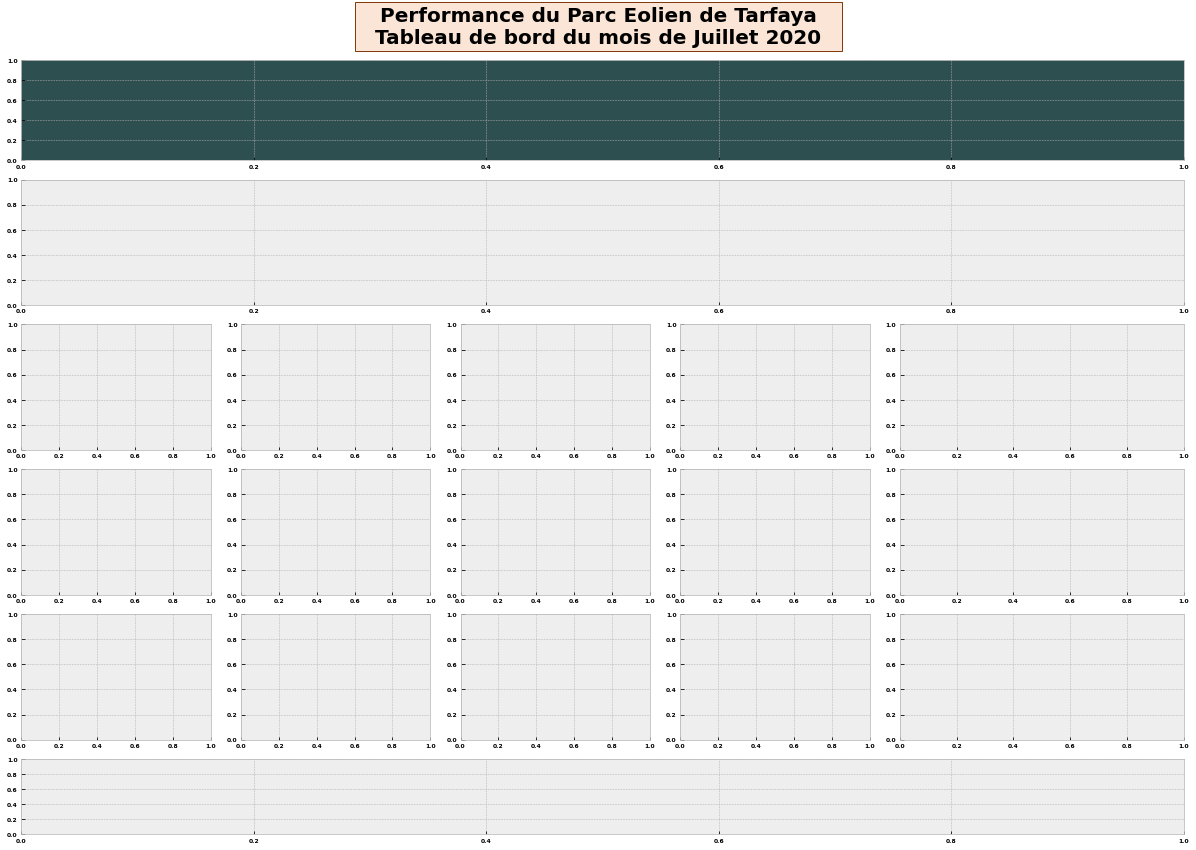

In [273]:
fig = plt.figure(constrained_layout=True, figsize=(22, 16))

# plt.rcParams.keys()
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


heights = [0.8, 1, 1, 1, 1, 0.6]
widths = [1, 1, 1, 1, 1.5]
gs = fig.add_gridspec(6, 5, height_ratios=heights, width_ratios=widths)


ax1 = fig.add_subplot(gs[0, :], facecolor=(.18, .31, .31))
# ax1.set_title('gs[0, :]')

ax2 = fig.add_subplot(gs[1, :])

ax3 = fig.add_subplot(gs[2, 0])

ax4 = fig.add_subplot(gs[2, 1])

ax5 = fig.add_subplot(gs[2, 2])

ax6 = fig.add_subplot(gs[2, 3])

ax7 = fig.add_subplot(gs[2, 4])

ax8 = fig.add_subplot(gs[3, 0])

ax9 = fig.add_subplot(gs[3, 1])

ax10 = fig.add_subplot(gs[3, 2])

ax11 = fig.add_subplot(gs[3, 3])

ax12 = fig.add_subplot(gs[3, 4])

ax13 = fig.add_subplot(gs[4, 0])

ax14 = fig.add_subplot(gs[4, 1])

ax15 = fig.add_subplot(gs[4, 2])

ax16 = fig.add_subplot(gs[4, 3])

ax17 = fig.add_subplot(gs[4, 4])

ax18 = fig.add_subplot(gs[5, :])


fig.suptitle('   Performance du Parc Eolien de Tarfaya   \n Tableau de bord du mois de Juillet 2020 ',
             fontsize=20, fontweight='heavy', fontstretch='ultra-expanded',
             bbox=dict(facecolor='#fbe5d6', edgecolor='#843c0c', linewidth=1))

fig.set_size_inches(16.5, 11.7)
# plot_children(fig, fig._layoutbox, printit=False)
# fig

## Format axs

In [278]:
text_box_ticks = dict()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_yticks([]), x.set_xticks([])
    # x.set_axis_off()



# fig.patch.set_facecolor('grey')

ax2.patch.set_facecolor('#deebf7')  

ax4.tick_params(labelsize=8, rotation=90)
# ax4.secondary_yaxis('right')



## Add data to axs

In [67]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib._layoutbox import plot_children

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    # items += [ax, ax.title]

    # Return a Bbox that contains all of the given bboxes.
    bbox = Bbox.union([item.get_window_extent() for item in items])
    # Construct a Bbox by expanding this one around its center by the factors sw and sh.
    # bbox.expanded(1.0 + pad, 1.0 + pad)
    return bbox

In [234]:
bbox

Bbox([[891.7071418181795, 404.660652481481], [1179.6872599999974, 534.0298726666662]])

In [262]:
lbrt = l, b, r, t = (ax7.get_window_extent().xmin,
              ax7.get_window_extent().ymin,
              ax7.get_window_extent().xmax,
              ax7.get_window_extent().ymax)

Bbox.from_extents(l, b, r, t)

Bbox([[891.707141818179, 404.66065248148107], [1179.6872599999972, 534.0298726666662]])

In [279]:
ax7.get_window_extent()._points

array([[ 899.75917455,  400.05485693],
       [1183.88702   ,  525.60463267]])

In [287]:
ax7._position

Bbox([[0.7505952372206904, 0.4803663965829547], [0.9930027441077427, 0.633938595283317]])

In [295]:
l, b, r, t = (ax7.get_window_extent()._points[0,0],
              ax7.get_window_extent()._points[0,1],
              ax7.get_window_extent()._points[1,0],
              ax7.get_window_extent()._points[1,1],)
bbox= Bbox.from_extents(l, b, r, t)

bbox

Bbox([[957.9071418181784, 421.86065248148105], [1245.8872599999966, 551.2298726666662]])

In [247]:
(Bbox.from_extents(l, b, r, t),
Bbox.from_extents(l, b, r, t).transformed(fig.transFigure.inverted()),
Bbox.from_extents(l, b, r, t).transformed(fig.transFigure.inverted()).transformed(fig.transFigure)
)

(Bbox([[895.5594145454526, 395.85509692592575], [1179.687259999998, 521.4048726666665]]),
 Bbox([[0.7538378910315257, 0.4699134578892756], [0.9930027441077425, 0.6189516532130419]]),
 Bbox([[895.5594145454525, 395.85509692592575], [1179.687259999998, 521.4048726666665]]))

In [294]:
vars(ax7.bbox)

{'_parents': {1541223939184: <weakref at 0x00000166D81B11D0; to 'BboxTransformTo' at 0x00000166D81AFC70>},
 '_invalid': 2,
 '_shorthand_name': '',
 '_bbox': Bbox([[0.7505952372206888, 0.48036639658295477], [0.9930027441077411, 0.6339385952833169]]),
 '_transform': <matplotlib.transforms.BboxTransformTo at 0x166d53fe5e0>,
 '_points': array([[ 957.90714182,  421.86065248],
        [1245.88726   ,  551.22987267]])}

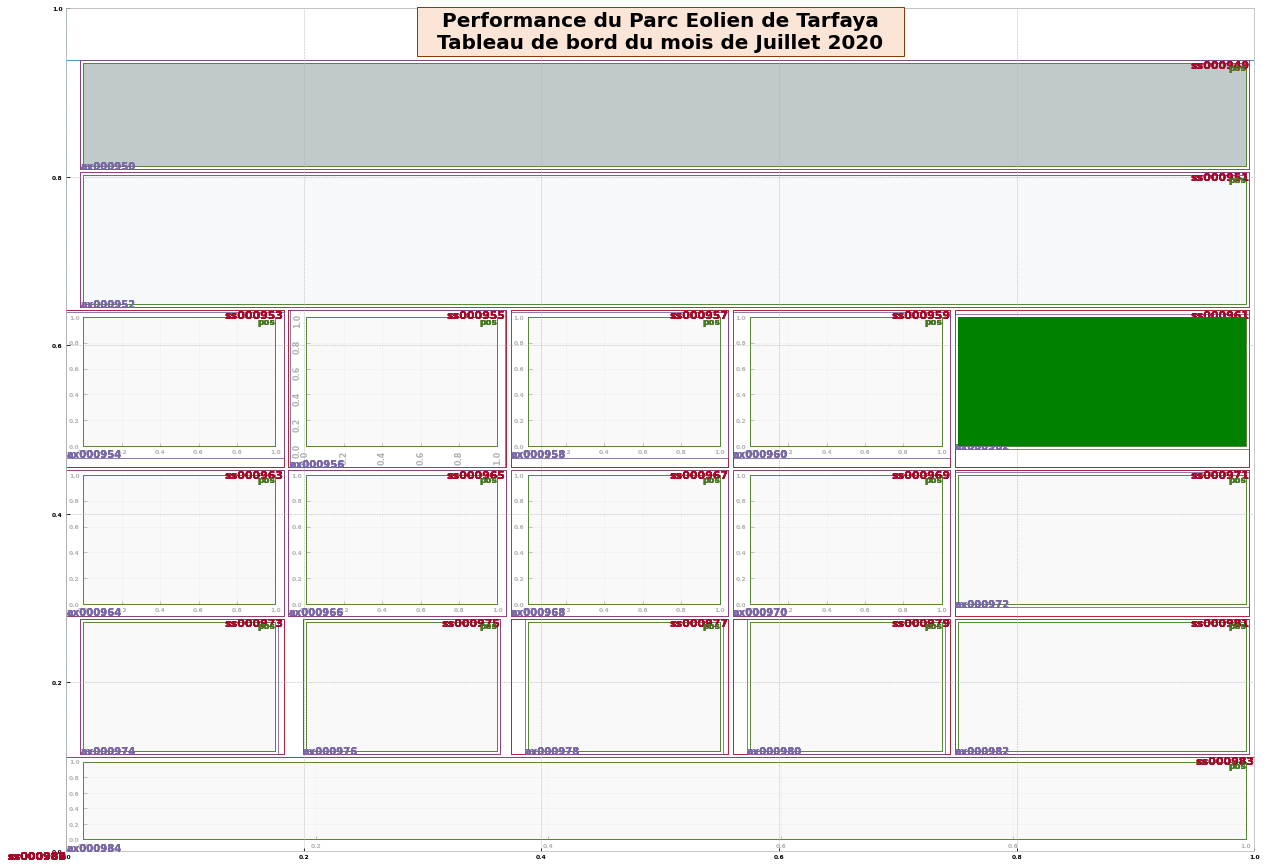

In [296]:
# extent = Bbox.union([full_extent(ax) for ax in axes[1,:]])

# It's best to transform this back into figure coordinates. Otherwise, it won't
# behave correctly when the size of the plot is changed.
extent = full_extent(ax7)

extent = extent.transformed(ax7.transAxes.inverted())



tblr = t, b, l, r = (ax7._layoutbox.top.value(),
                     ax7._layoutbox.bottom.value(),
                     ax7._layoutbox.left.value(),
                     ax7._layoutbox.right.value())


bbox = Bbox.from_extents(l, b, r, t)

# bbox = bbox.transformed(ax7.transAxes.inverted())
bbox = (gs[2, 4].get_position(fig))

bbox = ax7.get_window_extent()._points



lbrt = l, b, r, t = (ax7.get_window_extent().xmin,
              ax7.get_window_extent().ymin,
              ax7.get_window_extent().xmax,
              ax7.get_window_extent().ymax)
bbox= Bbox.from_extents(l, b, r, t).transformed(fig.transFigure.inverted())



bbox = ax7._originalPosition
l, b, r, t = (ax7.get_window_extent()._points[0,0],
              ax7.get_window_extent()._points[0,1],
              ax7.get_window_extent()._points[1,0],
              ax7.get_window_extent()._points[1,1],)
bbox= Bbox.from_extents(l, b, r, t).transformed(fig.transFigure.inverted())



# We can now make the rectangle in figure coords using the "transform" kwarg.
rect = Rectangle([bbox.xmin, bbox.ymin], bbox.width, bbox.height,
                 facecolor='green', edgecolor='none', zorder=2, 
                 transform=fig.transFigure
                 )



fig.patches.append(rect)

plot_children(fig, fig._layoutbox, printit=False)

fig

In [307]:
gs.get_grid_positions(fig)

(array([0.78412698, 0.64271429, 0.50130159, 0.35988889, 0.21847619,
        0.125     ]),
 array([0.88      , 0.76255556, 0.62114286, 0.47973016, 0.33831746,
        0.19690476]),
 array([0.125     , 0.27319749, 0.42139498, 0.56959248, 0.71778997]),
 array([0.24647335, 0.39467085, 0.54286834, 0.69106583, 0.9       ]))

In [256]:
(ax7.get_geometry())

(6, 5, 15)

In [286]:
vars(ax7)

{'figure': <Figure size 1188x842.4 with 19 Axes>,
 '_subplotspec': <matplotlib.gridspec.SubplotSpec at 0x166d8180430>,
 'figbox': Bbox([[0.7505952372206904, 0.4803663965829547], [0.9930027441077427, 0.633938595283317]]),
 'numRows': 6,
 'numCols': 5,
 '_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <matplotlib.axes._subplots.AxesSubplot at 0x166d81af970>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <bound method Figure._remove_ax of <Figure size 1188x842.4 with 19 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_posit

In [258]:
vars(ax7)

{'figure': <Figure size 1188x842.4 with 19 Axes>,
 '_subplotspec': <matplotlib.gridspec.SubplotSpec at 0x166d618c2e0>,
 'figbox': Bbox([[0.7505952372206904, 0.4803663965829547], [0.9930027441077427, 0.633938595283317]]),
 'numRows': 6,
 'numCols': 5,
 '_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <matplotlib.axes._subplots.AxesSubplot at 0x166d6474820>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <bound method Figure._remove_ax of <Figure size 1188x842.4 with 19 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_posit

In [195]:
fig.patches

In [260]:
vars(ax7.get_window_extent())

{'_parents': {1541193288480: <weakref at 0x00000166D6469810; to 'BboxTransformTo' at 0x00000166D6474B20>},
 '_invalid': 2,
 '_shorthand_name': '',
 '_bbox': Bbox([[0.7505952372206894, 0.48036639658295477], [0.9930027441077417, 0.633938595283317]]),
 '_transform': <matplotlib.transforms.BboxTransformTo at 0x166d1fb7370>,
 '_points': array([[ 957.90714182,  421.86065248],
        [1245.88726   ,  551.22987267]])}

In [179]:
(gs[2, 4].get_position(fig))

Bbox([[0.7177899686520377, 0.5013015873015872], [0.9000000000000001, 0.6211428571428571]])

In [191]:
gs[2, 4].get_position()?

Object `get_position` not found.


In [178]:
dir(gs[2, 4])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gridspec',
 '_layoutbox',
 '_num2',
 'colspan',
 'get_geometry',
 'get_gridspec',
 'get_position',
 'get_rows_columns',
 'get_topmost_subplotspec',
 'num1',
 'num2',
 'rowspan',
 'subgridspec']

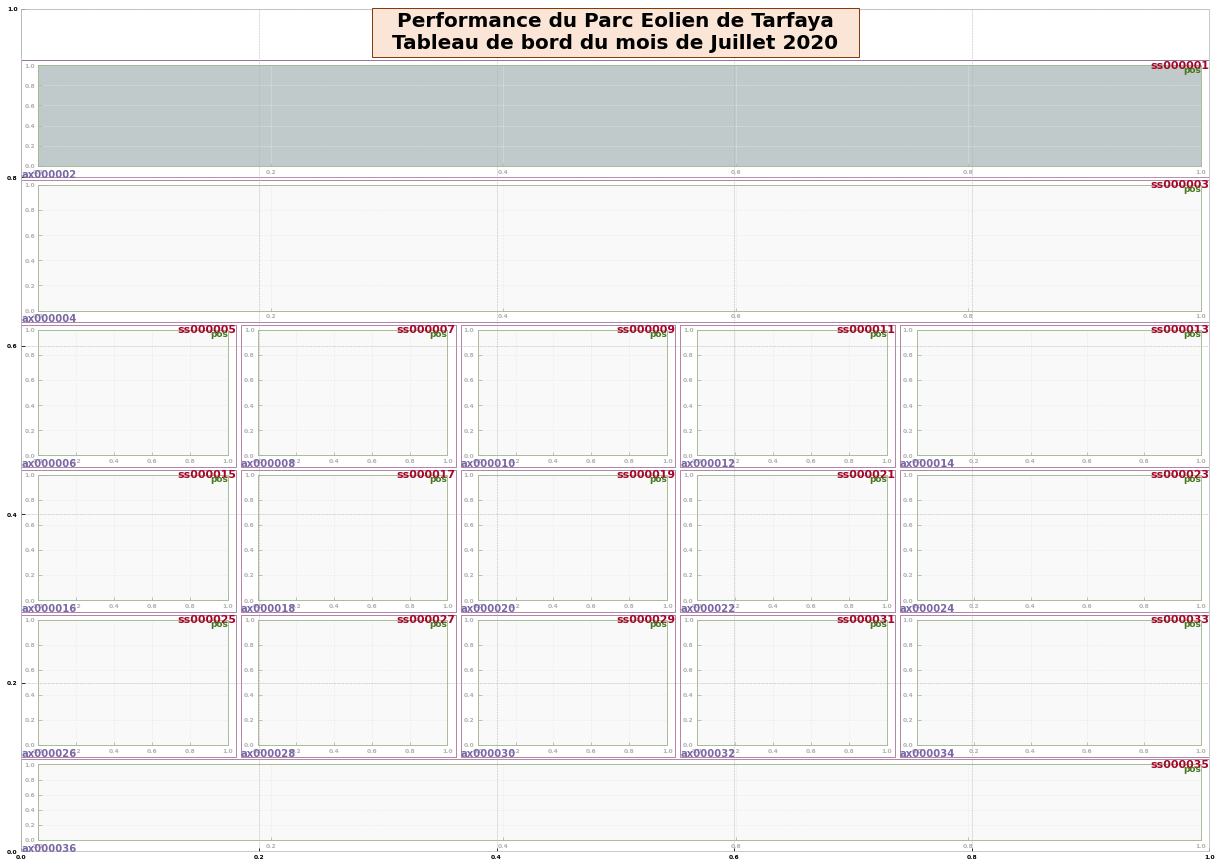

In [56]:
plot_children(fig, fig._layoutbox, printit=False)
fig

In [157]:
ax1.cla()
ax1.set_axis_off()
table1 = ax1.table(cellText=df_ax1.to_numpy().tolist(),
                   colLabels=df_ax1.columns.tolist(),
                   rowLabels=df_ax1.index.tolist(),
                   bbox = [0,0,1,0.7])


table1.auto_set_font_size(False)
table1.set_fontsize(7)
# table1.auto_set_column_width(col=list(range(len(df_ax1.columns))))
table1._cells[(1,-1)].set_width(0.1)
table1._cells[(2,-1)].set_width(0.1)

col_nmbrs = df_ax1.to_numpy().shape[1]

for i in range(-1, col_nmbrs):
    table1[(1,i)].set_facecolor('#fff2cc')
    table1[(2,i)].set_facecolor('#fbe5d6')


In [158]:
# for i in range(3,10):
#     eval(f'ax{i}.cla()')


df_ax3.plot(kind='bar', x='Error Group', ax=ax3, width=0.95, rot=75)
ax3.set_title('Cumul annuel par type d\'alarme',
                fontsize=8)

df_ax5.plot(kind='bar', x='Error Group', ax=ax5, width=0.95, rot=75)
ax5.set_title(f'Type d\'alarme {period}',
                fontsize=8)

df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6, width=0.95)
ax6.set_title(f'Alarmes {period}',
                fontsize=8)

df_ax8.plot(kind='bar', x='StationId', ax=ax8, width=0.95)
ax8.set_title('Arrêts turbines : Cumul Annuel',
                fontsize=8)

df_ax9.plot(kind='bar', x='StationId', ax=ax9, width=0.95)
ax9.set_title(f'Arrêts turbines {period}',
                fontsize=8)


ax8.legend(ncol=2, fontsize=7)
ax9.legend(ncol=2, fontsize=7, frameon=True)




In [159]:
from matplotlib.ticker import ScalarFormatter

ax18.cla()
ax18.bar(df_ax18['StationId'].astype('str'), df_ax18['ELNX'], label='ELNX')
ax18.bar(df_ax18['StationId'].astype('str'), df_ax18['EL_indefini_left'], bottom=df_ax18['ELNX'],
       label='EL_indefini_left')

ax18.set_xlabel('StationId')
ax18.set_title('Energie perdue selon FSA cumulée sur l\'année 2020 en MWh',
                fontsize=8)
ax18.tick_params(axis='x', labelsize=6, rotation=90)
ax18.tick_params(axis='y', labelsize=5)

sf = ScalarFormatter(useMathText=True)
# sf.set_scientific(True)
sf.set_powerlimits((3, 3))
ax18.yaxis.set_major_formatter(sf)

ax18.yaxis.offsetText.set_fontsize(5)

ax18.legend(fontsize=7)

In [162]:
vars(fig)

{'_stale': True,
 'stale_callback': None,
 'figure': None,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': None,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'callbacks': <matplotlib.cbook.CallbackRegistry at 0x19626779c70>,
 'bbox_inches': Bbox([[0.0, 0.0], [16.5, 11.7]]),
 'dpi_scale_trans': <matplotlib.transforms.Affine2D at 0x19626779b50>,
 '_dpi': 72.0,
 'bbox': <matplotlib.transforms.TransformedBbox at 0x19626779460>,
 'transFigure': <matplotlib.transforms.BboxTransformTo at 0x19626779040>,
 'patch': <matplotlib.patches.Rectangle at 0x19626779ac0>,
 'canvas': <matplotlib.backends.b

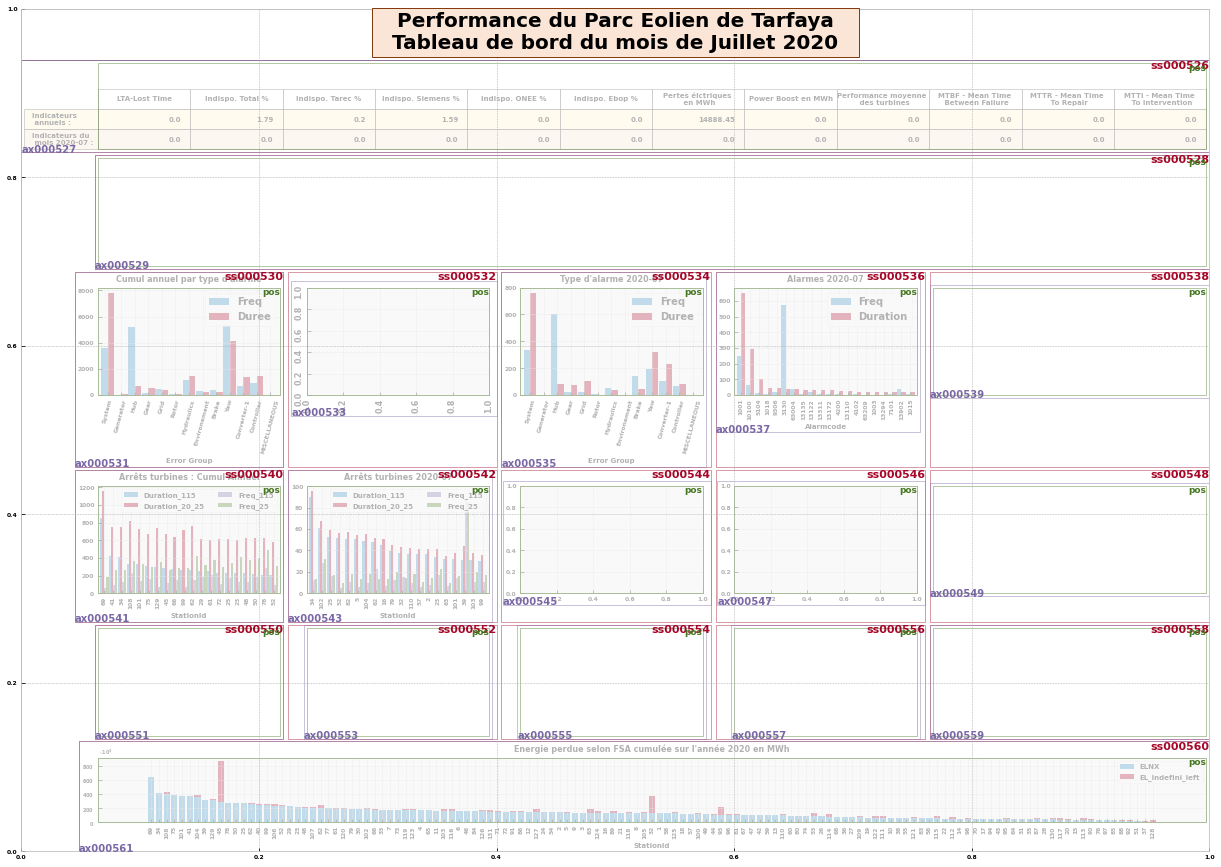

In [160]:
plot_children(fig, fig._layoutbox, printit=False)
fig

In [209]:
fig.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2)

# Testing figures

In [99]:
import matplotlib as mpl

def mergecells(table, ix0, ix1):
    ix0,ix1 = np.asarray(ix0), np.asarray(ix1)
    d = ix1 - ix0
    if not (0 in d and 1 in np.abs(d)):
        raise ValueError("ix0 and ix1 should be the indices of adjacent cells. ix0: %s, ix1: %s" % (ix0, ix1))

    if d[0]==-1:
        edges = ('BRL', 'TRL')
    elif d[0]==1:
        edges = ('TRL', 'BRL')
    elif d[1]==-1:
        edges = ('BTR', 'BTL')
    else:
        edges = ('BTL', 'BTR')

    # hide the merged edges
    for ix,e in zip((ix0, ix1), edges):
        table[ix[0], ix[1]].visible_edges = e

    txts = [table[ix[0], ix[1]].get_text() for ix in (ix0, ix1)]
    tpos = [np.array(t.get_position()) for t in txts]

    # center the text of the 0th cell between the two merged cells
    trans = (tpos[1] - tpos[0])/2
    if trans[0] > 0 and txts[0].get_ha() == 'right':
        # reduce the transform distance in order to center the text
        trans[0] /= 2
    elif trans[0] < 0 and txts[0].get_ha() == 'right':
        # increase the transform distance...
        trans[0] *= 2

    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))

    # hide the text in the 1st cell
    txts[1].set_visible(False)

In [469]:
import numpy as np
import matplotlib.pyplot as plt


data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = [f'{x} year' for x in (100, 50, 20, 10, 5)]


# Add a table at the bottom of the axes
ax1.cla()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_axis_off()

table = ax1.table(cellText=np.vstack([columns, data]),
                #   rowLabels=rows,
                #   colLabels=columns,
                  loc='center',
                  bbox = [0,0,1,1])

# mergecells(table, (1,0), (0,0))
# mergecells(table, (1,1), (0,1))
# mergecells(table, (0,2), (0,3))

# ax1.show()

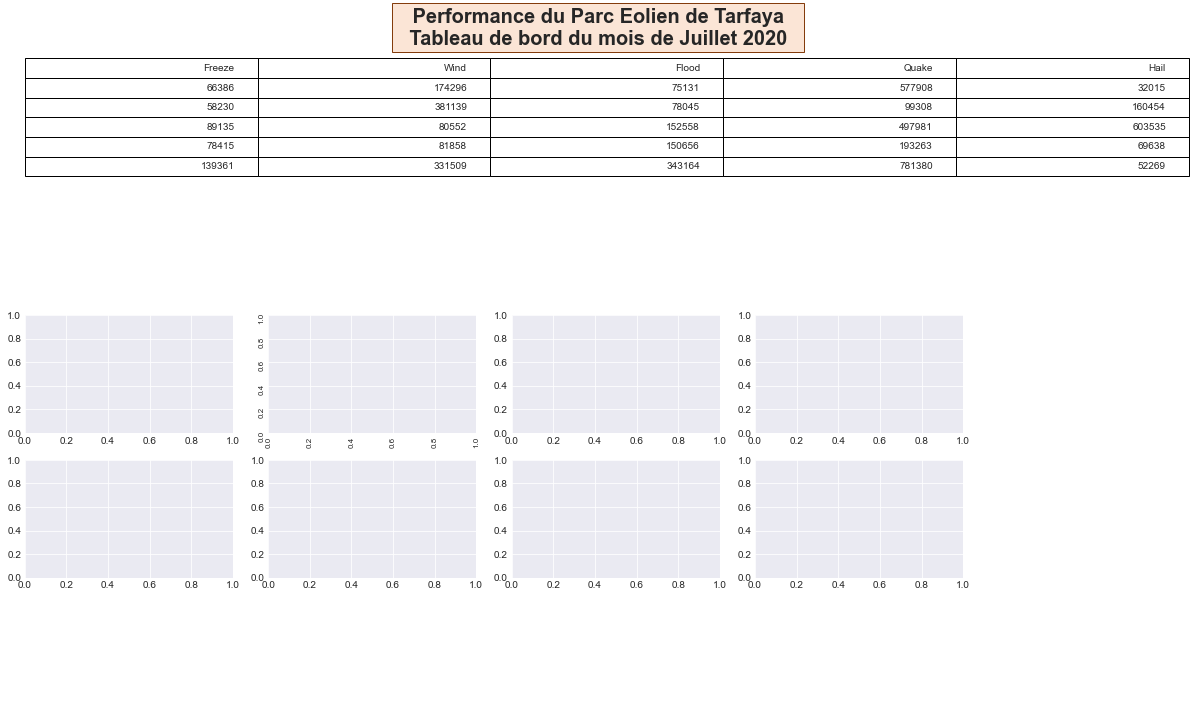

In [470]:
ax1.figure

### -----------------------------------------------------------------------------------------------
### Pandas dataframe to matplotlib table

In [475]:
df = (main_result_sum.groupby('Station')
                .sum()
                .head(5))

df

,Alarmcode,ID
StationNr,,
2307405,36527,17905792
2307406,37528,20950079
2307407,44326,45067457
2307408,183002,66048558
2307409,60010,68652519


In [481]:
ax1.cla()
ax1.set_axis_off()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_yticks([]), x.set_xticks([])

pd.plotting.table(ax1, df, colLabels=[], bbox = [0,0,1,1])

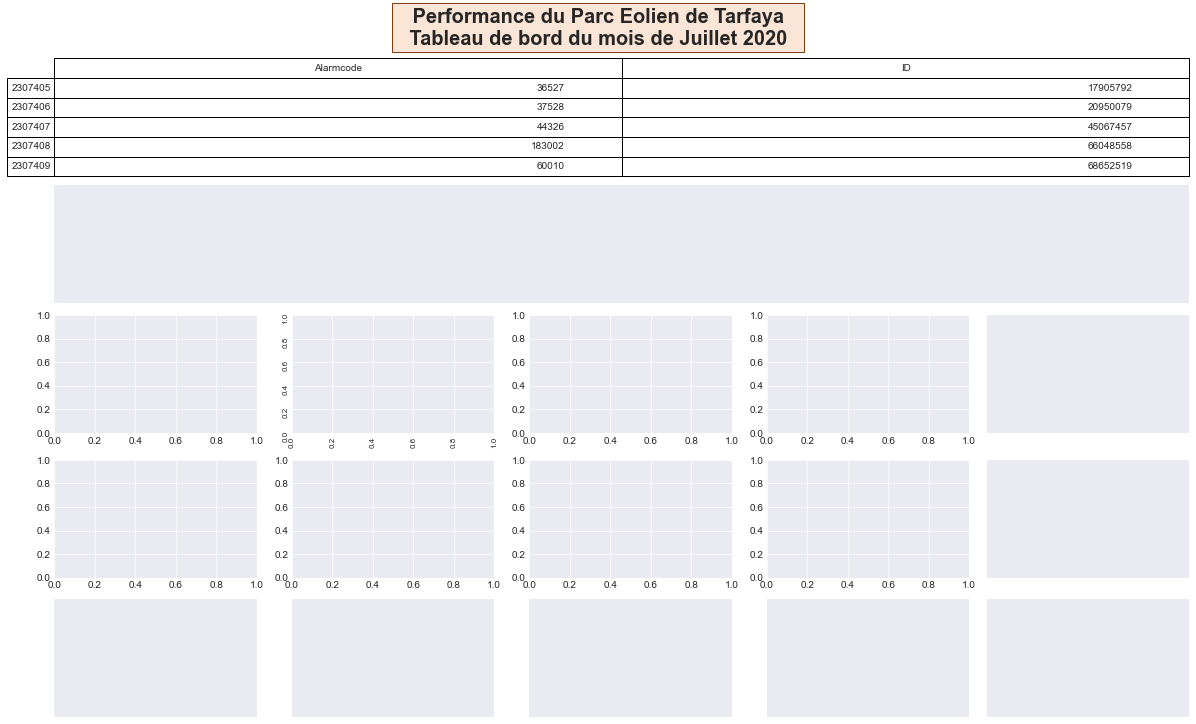

In [482]:
fig

### ----------------------------------------------------------------------------------------------------

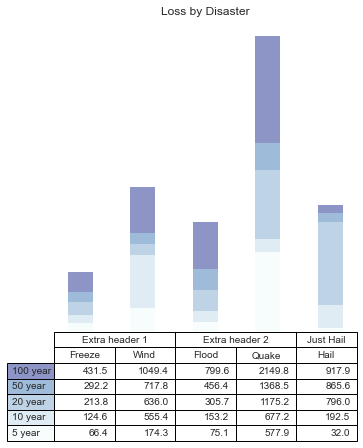

In [417]:


data = [[  66386,  174296,   75131,  577908,   32015],
        [  58230,  381139,   78045,   99308,  160454],
        [  89135,   80552,  152558,  497981,  603535],
        [  78415,   81858,  150656,  193263,   69638],
        [ 139361,  331509,  343164,  781380,   52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add headers and a table at the bottom of the axes
header_0 = plt.table(cellText=[['']*2],
                     colLabels=['Extra header 1', 'Extra header 2'],
                     loc='bottom',
                     bbox=[0, -0.1, 0.8, 0.1]
                     )

header_1 = plt.table(cellText=[['']],
                     colLabels=['Just Hail'],
                     loc='bottom',
                     bbox=[0.8, -0.1, 0.2, 0.1]
                     )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',
                      bbox=[0, -0.35, 1.0, 0.3]
                      )

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=-0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

In [247]:
with pd.ExcelWriter('output.xlsx') as writer:  
    print('working same code')
    df_ax3.to_excel(writer, index=False, sheet_name='ax3')
    workbook = writer.book
    workbook = writer.sheets['ax3']

working same code


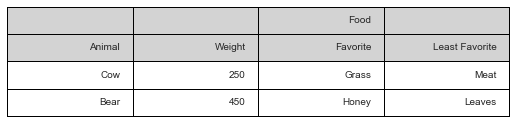

In [450]:
df = pd.DataFrame()
df['Animal'] = ['Cow', 'Bear']
df['Weight'] = [250, 450]
df['Favorite'] = ['Grass', 'Honey']
df['Least Favorite'] = ['Meat', 'Leaves']

fig = plt.figure(figsize=(9,2))
ax=fig.gca()
ax.axis('off')
r,c = df.shape

# ensure consistent background color
ax.table(cellColours=[['lightgray']] + [['none']], bbox=[0,0,1,1])

# plot the real table
table = ax.table(cellText=np.vstack([['', '', 'Food', ''], df.columns, df.values]), 
                 cellColours=[['none']*c]*(2 + r), bbox=[0, 0, 1, 1])

# need to draw here so the text positions are calculated
fig.canvas.draw()

In [453]:
np.vstack([['', '', 'Food', ''], df.columns, df.values])

array([['', '', 'Food', ''],
       ['Animal', 'Weight', 'Favorite', 'Least Favorite'],
       ['Cow', 250, 'Grass', 'Meat'],
       ['Bear', 450, 'Honey', 'Leaves']], dtype=object)

# Export Data to excel

In [ ]:
writer = pd.ExcelWriter('output.xlsx')

workbook = writer.book
dashsheet = workbook.add_worksheet('Dash')

df_ax3.to_excel(writer, index=False, sheet_name='ax3')
worksheet = writer.sheets['ax3']


def make_chart_ax3():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax3', 1, 1, 13, 1],
                             'categories': ['ax3', 1, 0, 13, 0],
                             'name': ['ax3', 0, 1]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'name': ['ax3', 0, 2],
        'categories': ['ax3', 1, 0, 13, 0],
        'values': ['ax3', 1, 2, 13, 2],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax3.columns[0]})
    column_chart.set_y_axis({'name': df_ax3.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Cumul annuel par type d\'alarme',
                            'name_font': {'size': 12, 'bold': True}})
    line_chart.set_y2_axis({'name': df_ax3.columns[2]})
    return column_chart


column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
dashsheet.insert_chart('E42', column_chart)


# -------------------------------------------------------------------------------------------
df_ax5.to_excel(writer, index=False, sheet_name='ax5')

worksheet = writer.sheets['ax5']


def make_chart_ax5():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax5', 1, 1, 13, 1],
                             'categories': ['ax5', 1, 0, 13, 0],
                             'name': ['ax5', 0, 1]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'name': ['ax5', 0, 2],
        'categories': ['ax5', 1, 0, 13, 0],
        'values': ['ax5', 1, 2, 13, 2],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax5.columns[0]})
    column_chart.set_y_axis({'name': df_ax5.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Type d\'alarme {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax5.columns[2]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U42', column_chart)


# --------
df_ax6.to_excel(writer, index=False, sheet_name='ax6')

worksheet = writer.sheets['ax6']


def make_chart_ax6():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax6', 1, 1, 20, 1],
                             'categories': ['ax6', 1, 0, 20, 0],
                             'name': ['ax6', 0, 1]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'name': ['ax6', 0, 2],
        'categories': ['ax6', 1, 0, 20, 0],
        'values': ['ax6', 1, 2, 20, 2],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax6.columns[0]})
    column_chart.set_y_axis({'name': df_ax6.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Alarmes {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax6.columns[2]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
dashsheet.insert_chart('AC42', column_chart)


# ------------------------------------------------------------------------------------------------
df_ax8.to_excel(writer, index=False, sheet_name='ax8')

worksheet = writer.sheets['ax8']


def make_chart_ax8():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax8', 1, 3, 20, 3],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'name': ['ax8', 0, 3]})

    column_chart.add_series({'values': ['ax8', 1, 4, 20, 4],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'name': ['ax8', 0, 4]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'name': ['ax8', 0, 1],
        'categories': ['ax8', 1, 0, 20, 0],
        'values': ['ax8', 1, 1, 20, 1],
        'y2_axis': True,
    })

    line_chart.add_series({
        'name': ['ax8', 0, 2],
        'categories': ['ax8', 1, 0, 20, 0],
        'values': ['ax8', 1, 2, 20, 2],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax8.columns[0]})
    column_chart.set_y_axis({'name': 'Freq'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Arrêts turbines : Cumul Annuel',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Duration'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
dashsheet.insert_chart('E58', column_chart)


# ----------------------------------------------------------------------------------------
# --------
df_ax9.to_excel(writer, index=False, sheet_name='ax9')

worksheet = writer.sheets['ax9']


def make_chart_ax9():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax9', 1, 3, 20, 3],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'name': ['ax9', 0, 3]})

    column_chart.add_series({'values': ['ax9', 1, 4, 20, 4],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'name': ['ax9', 0, 4]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'name': ['ax9', 0, 1],
        'categories': ['ax9', 1, 0, 20, 0],
        'values': ['ax9', 1, 1, 20, 1],
        'y2_axis': True,
    })

    line_chart.add_series({
        'name': ['ax9', 0, 2],
        'categories': ['ax9', 1, 0, 20, 0],
        'values': ['ax9', 1, 2, 20, 2],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax9.columns[0]})
    column_chart.set_y_axis({'name': 'Freq'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Arrêts turbines {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Duration'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
dashsheet.insert_chart('M58', column_chart)

# ----------------------------------------------------------------------------------------
df_ax18.to_excel(writer, index=False, sheet_name='ax18')

worksheet = writer.sheets['ax18']


def make_chart_ax18():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    for col in range(1, 3):
        column_chart.add_series({'values': ['ax18', 1, col, 20, col],
                                 'categories': ['ax18', 1, 0, 20, 0],
                                 'name': ['ax18', 0, col]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax18.columns[0]})
    # column_chart.set_y_axis({'name': df_ax18.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': 'Energie perdue selon FSA cumulée sur l\'année 2020 en MWh',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U58', column_chart)


writer.save()

# Report lab

In [1]:
from reportlab.pdfgen import canvas
from reportlab.lib import pdfencrypt
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import landscape, A3
from reportlab.pdfbase.pdfmetrics import stringWidth



In [40]:
pdf = canvas.Canvas('home.pdf', pagesize=landscape(A3), bottomup=0,
                    verbosity=1)
# pdf.translate(inch, inch)

pdf.saveState()
pdf.setStrokeColorRGB(132/255, 60/255, 12/255)
pdf.setFillColorRGB(251/255, 229/255, 214/255)
PAGE_WIDTH = pdf._pagesize[0]/72

#------------------------------------------------------------------------
title = 'Performance du Parc Eolien de Tarfaya \n Tableau de bord du mois de Juillet 2020'
title_width = stringWidth(title, 'Helvetica-Bold', 15)
pdf.setFont('Helvetica-Bold', 15)
# center rectangle on x
width = title_width/72 + 0.1 # inches
x = PAGE_WIDTH/2 - width/2 # inches
y = 0.16
height = 0.7
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

x_string = PAGE_WIDTH/2 - title_width/72/2
y_string = height/2 + y

pdf.setFillColorRGB(0,0,0)
pdf.drawCentredString(PAGE_WIDTH/2*inch, y_string*inch, title)

#------------------------------------------------------------------------
pdf.setFillColorRGB(255/255, 242/255, 204/255)
# center rectangle on x
width = 14 # inches
x = PAGE_WIDTH/2 - width/2 # points

pad = 0.1
y = y + height + pad
height = 1
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)
#------------------------------------------------------------------------
pdf.setFillColorRGB(251/255, 229/255, 214/255)
pad = 0.08
y = y + height + pad
height = 1
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

#------------------------------------------------------------------------
pdf.setFillColorRGB(222/255, 235/255, 247/255)

width = 15 # inches
x = PAGE_WIDTH/2 - width/2 # points
pad = 0.12
y = y + height + pad
height = 1.3
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

pdf.save()

saved home.pdf


In [24]:
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
canv = canvas.Canvas('sizetest.pdf', bottomup=0)
fontname = 'Helvetica'
fontsize = 8

face = pdfmetrics.getFont(fontname).face
ascent = (face.ascent * fontsize) / 1000.0
descent = (face.descent * fontsize) / 1000.0

height = ascent - descent # <-- descent it's negative

#draw a box 10 wide and "height" tall
canv.rect(50, 10, 60, height) # <--to keep the baseline at 600

#Write the string next to the box, it should be the exact same height
canv.setFont(fontname, fontsize) # <-- fix the size of your output text
canv.drawString(62,10 + height,'Testing')

canv.save()

height/72

0.10277777777777777

In [9]:
(ascent,
descent,
height)

(5.744, -1.656, 7.3999999999999995)

In [23]:
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import letter
from reportlab.platypus import Paragraph, SimpleDocTemplate, Flowable, Spacer
from reportlab.graphics.shapes import Drawing, Rect

my_doc = SimpleDocTemplate('myfile.pdf', pagesize=landscape(A3), buttomup=0)
flowables = []
my_doc.build(flowables)
styles = getSampleStyleSheet()

paragraph_1 = Paragraph("A litle bit of this", styles['Heading1'])
paragraph_2 = Paragraph('Some normal body text', styles['BodyText'])

flowables.extend([paragraph_1, paragraph_2])

my_doc.build(flowables)

In [15]:
styles['BodyText']

<ParagraphStyle 'BodyText'>

# Jinja2